# Introduction to Artificial Neural Networks with Keras

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Perceptrons

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris['data'][:, (2,3)] #petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42) #per_cf means perceptron classifier
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

Saving figure perceptron_iris_plot


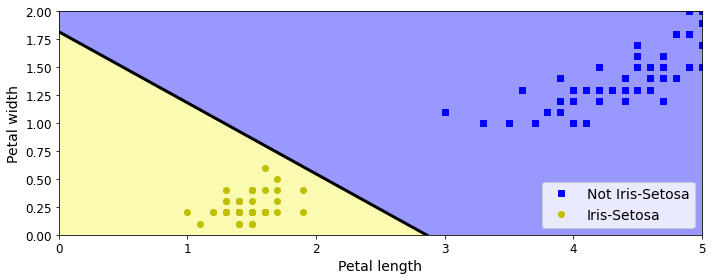

In [4]:
axes = [0, 5, 0, 2]

a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], 'k-', linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z+eps) - f(z-eps)) / (2 * eps)

Saving figure activation_functions_plot


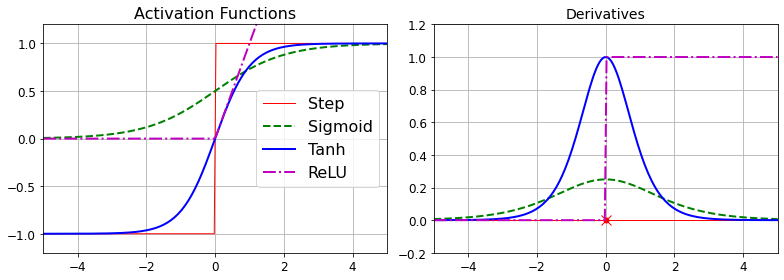

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label="Step")
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, np.tanh(z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, relu(z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc="center right", fontsize=16)
plt.title("Activation Functions", fontsize=16)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), 'r-', linewidth=1, label='Step')
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [7]:
def heaviside(z):
    return (z >=0 ).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

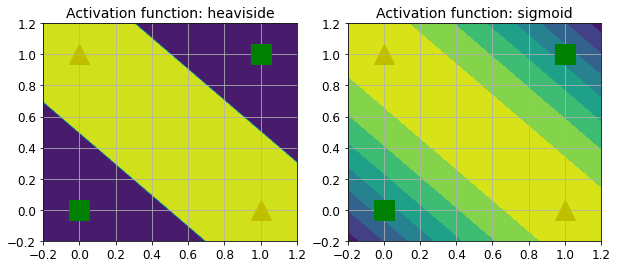

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
tf.__version__

'2.4.1'

In [11]:
keras.__version__

'2.4.0'

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28 * 28 pixels:

In [13]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented by a byte (0 to 255)

In [14]:
X_train_full.dtype

dtype('uint8')

Spliting the  training set into validation set and smaller training set. Also, scaling the pixel intensities down to 0-1 range and converting them to floats, by dividing by 255

In [15]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using matplotlib's `imshow()` function with a `binary` color map.

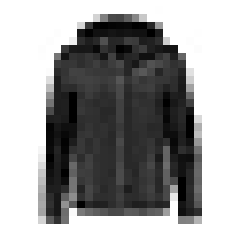

In [16]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

The labels are the class id's (as uint8), from 0-9

In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are some corresponding class names:

In [18]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [19]:
class_names[y_train[0]]

'Coat'

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

Saving figure fashion_mnist_plot


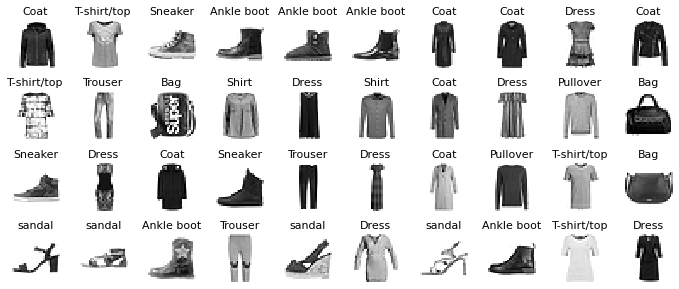

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=11)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.layers

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


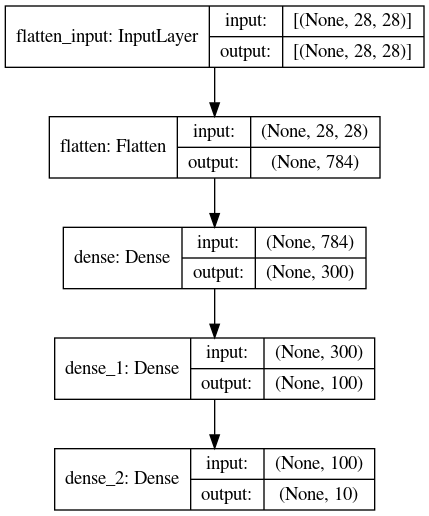

In [28]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [29]:
hidden2 = model.layers[2]
hidden2.name

'dense_1'

In [30]:
model.get_layer(hidden2.name) is hidden2

True

In [31]:
weights, biases = hidden2.get_weights()

In [32]:
weights

array([[ 0.04602376, -0.0038019 ,  0.10557164, ...,  0.05382182,
        -0.09810888,  0.10975555],
       [-0.0131605 , -0.0401491 , -0.01301397, ..., -0.06764732,
        -0.05142808, -0.10832162],
       [ 0.0748878 ,  0.11689269,  0.06693598, ...,  0.04704887,
        -0.04119989,  0.1031863 ],
       ...,
       [-0.08606555,  0.1186113 , -0.11932244, ...,  0.1080649 ,
        -0.10135629,  0.05048553],
       [-0.1144025 , -0.06622341,  0.00440084, ..., -0.00439373,
         0.01447021,  0.02337808],
       [-0.10965011,  0.05632766,  0.11904002, ..., -0.0713827 ,
         0.11915682, -0.10558839]], dtype=float32)

In [33]:
weights.shape

(300, 100)

In [34]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [35]:
biases.shape

(100,)

In [36]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [37]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 1.0188 - accuracy: 0.6805 - val_loss: 0.5219 - val_accuracy: 0.8206
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5027 - accuracy: 0.8262 - val_loss: 0.4352 - val_accuracy: 0.8524
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4482 - accuracy: 0.8419 - val_loss: 0.5358 - val_accuracy: 0.7984
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4206 - accuracy: 0.8528 - val_loss: 0.3923 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4059 - accuracy: 0.8577 - val_loss: 0.3747 - val_accuracy: 0.8690
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3753 - accuracy: 0.8678 - val_loss: 0.3718 - val_accuracy: 0.8718
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3653 - accuracy: 0.8703 - val_loss: 0.3622 - val_accuracy:

In [38]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [39]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure kears_learning_curves_plot


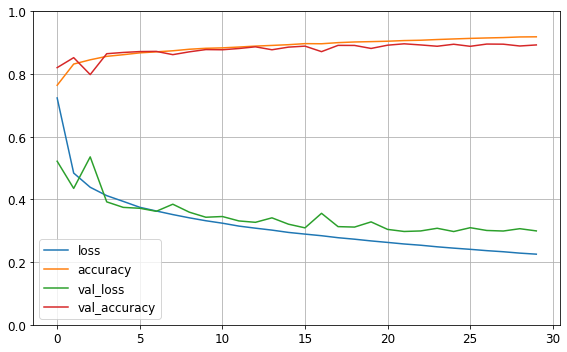

In [41]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend(loc='lower left', fontsize=12)
save_fig("kears_learning_curves_plot")
plt.show()

In [42]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3335 - accuracy: 0.8840


[0.33352765440940857, 0.8840000033378601]

In [43]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [44]:
class_names[y_test[0]]

'Ankle boot'

In [45]:
# y_pred = model.predict_classes(X_new) # depreciated
y_pred = np.argmax(model.predict(X_new), axis=1)
y_pred

array([9, 2, 1])

In [46]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [47]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


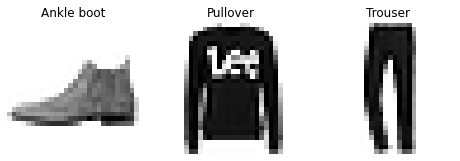

In [48]:
plt.figure(figsize=(8, 3))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split, and scale the California housing dataset (the original one, not the modified one)

In [49]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.2656 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 732us/step - loss: 0.7413 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 761us/step - loss: 0.6604 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 726us/step - loss: 0.6245 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 714us/step - loss: 0.5770 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 749us/step - loss: 0.5609 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 782us/step - loss: 0.5500 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 768us/step - loss: 0.5200 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 673us/step - loss: 0.5051 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 703us/step - loss: 0.4910 

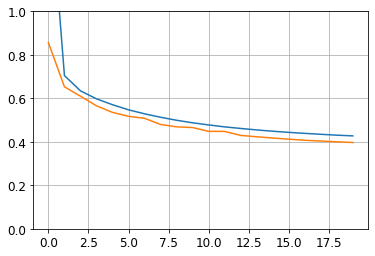

In [52]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [53]:
y_pred

array([[0.3885664],
       [1.6792021],
       [3.1022797]], dtype=float32)

In [54]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

# Functional API

Not all neural network models are sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide and Deep Neural Network connects all or part of the inputs directly to the output layer.

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
input_ = keras.layers.Input(shape=X_train.shape[1:]) # The name input_ is used to avoid overshadowing Python’s built-in input() function.
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [58]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 908us/step - loss: 1.9731 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 0s 679us/step - loss: 0.7638 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 0s 698us/step - loss: 0.6045 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 0s 733us/step - loss: 0.5862 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 0s 770us/step - loss: 0.5452 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 0s 750us/step - loss: 0.5243 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 0s 709us/step - loss: 0.5185 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 0s 691us/step - loss: 0.4947 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 0s 725us/step - loss: 0.4782 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 0s 742us/step - loss: 0.470

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [59]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [60]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_new[:, :5], X_new[:, 2:]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 933us/step - loss: 2.9131 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 711us/step - loss: 0.8125 - val_loss: 0.6710
Epoch 3/20
363/363 [==============================] - 0s 712us/step - loss: 0.6876 - val_loss: 0.6169
Epoch 4/20
363/363 [==============================] - 0s 707us/step - loss: 0.6241 - val_loss: 0.5710
Epoch 5/20
363/363 [==============================] - 0s 708us/step - loss: 0.5770 - val_loss: 0.5420
Epoch 6/20
363/363 [==============================] - 0s 709us/step - loss: 0.5416 - val_loss: 0.5176
Epoch 7/20
363/363 [==============================] - 0s 734us/step - loss: 0.5449 - val_loss: 0.5065
Epoch 8/20
363/363 [==============================] - 0s 706us/step - loss: 0.5136 - val_loss: 0.4790
Epoch 9/20
363/363 [==============================] - 0s 771us/step - loss: 0.4917 - val_loss: 0.4564
Epoch 10/20
363/363 [==============================] - 0s 806us/step - loss: 0.478

Adding an auxiliary output for regularization:

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [62]:
model.compile(loss=['mse', 'mse'], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [63]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                   validation_data=([X_valid_A, X_valid_B]))

Epoch 1/20
363/363 [==============================] - 1s 986us/step - loss: 4.0467 - main_output_loss: 3.6523 - aux_output_loss: 7.5962 - val_loss: 0.0000e+00 - val_main_output_loss: 0.0000e+00 - val_aux_output_loss: 0.0000e+00
Epoch 2/20
363/363 [==============================] - 0s 791us/step - loss: 1.3263 - main_output_loss: 0.9168 - aux_output_loss: 5.0120 - val_loss: 0.0000e+00 - val_main_output_loss: 0.0000e+00 - val_aux_output_loss: 0.0000e+00
Epoch 3/20
363/363 [==============================] - 0s 791us/step - loss: 0.9137 - main_output_loss: 0.6985 - aux_output_loss: 2.8500 - val_loss: 0.0000e+00 - val_main_output_loss: 0.0000e+00 - val_aux_output_loss: 0.0000e+00
Epoch 4/20
363/363 [==============================] - 0s 883us/step - loss: 0.7598 - main_output_loss: 0.6338 - aux_output_loss: 1.8944 - val_loss: 0.0000e+00 - val_main_output_loss: 0.0000e+00 - val_aux_output_loss: 0.0000e+00
Epoch 5/20
363/363 [==============================] - 0s 864us/step - loss: 0.6852 - mai

In [64]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test]
)
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 987us/step - loss: 0.4622 - main_output_loss: 0.4211 - aux_output_loss: 0.8314


# The subclassing API

In [65]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
    
model = WideAndDeepModel(30, activation='relu')

In [66]:
model.compile(loss='mse', loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=10,
                   validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test]
)
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 3.8971 - output_1_loss: 3.6960 - output_2_loss: 5.7076 - val_loss: 4.0827 - val_output_1_loss: 3.6804 - val_output_2_loss: 7.7037
Epoch 2/10
363/363 [==============================] - 0s 833us/step - loss: 1.2810 - output_1_loss: 0.9430 - output_2_loss: 4.3225 - val_loss: 1.8117 - val_output_1_loss: 0.9127 - val_output_2_loss: 9.9026
Epoch 3/10
363/363 [==============================] - 0s 832us/step - loss: 0.8913 - output_1_loss: 0.6705 - output_2_loss: 2.8791 - val_loss: 1.6652 - val_output_1_loss: 0.6103 - val_output_2_loss: 11.1593
Epoch 4/10
363/363 [==============================] - 0s 828us/step - loss: 0.7669 - output_1_loss: 0.6166 - output_2_loss: 2.1194 - val_loss: 1.6267 - val_output_1_loss: 0.5937 - val_output_2_loss: 10.9233
Epoch 5/10
363/363 [==============================] - 0s 865us/step - loss: 0.6951 - output_1_loss: 0.5736 - output_2_loss: 1.7883 - val_loss: 1.4905 - val_output_1_loss: 0.559

## Saving and Restoring

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

In [68]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [70]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 925us/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 772us/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 685us/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 755us/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 770us/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 756us/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 427us/step - loss: 0.4382


In [71]:
model.save("my_keras_model.h5")

In [72]:
model = keras.models.load_model("my_keras_model.h5")

In [73]:
model.predict(X_new)

array([[0.5400236],
       [1.6505969],
       [3.0098243]], dtype=float32)

In [74]:
model.save_weights("my_keras_weights.ckpt")

In [75]:
model.load_weights("my_keras_weights.ckpt")

## Using callbacks during training

In [77]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [78]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [85]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model('my_keras_model.h5') # rollback to best model

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 0.4077 - val_loss: 0.3695
Epoch 2/10
363/363 [==============================] - 0s 931us/step - loss: 0.4031 - val_loss: 0.3684
Epoch 3/10
363/363 [==============================] - 0s 974us/step - loss: 0.4014 - val_loss: 0.3650
Epoch 4/10
363/363 [==============================] - 0s 976us/step - loss: 0.3999 - val_loss: 0.3632
Epoch 5/10
363/363 [==============================] - 0s 722us/step - loss: 0.3913 - val_loss: 0.3608
Epoch 6/10
363/363 [==============================] - 0s 685us/step - loss: 0.3845 - val_loss: 0.3585
Epoch 7/10
363/363 [==============================] - 0s 683us/step - loss: 0.3954 - val_loss: 0.3564
Epoch 8/10
363/363 [==============================] - 0s 712us/step - loss: 0.3880 - val_loss: 0.3560
Epoch 9/10
363/363 [==============================] - 0s 762us/step - loss: 0.3795 - val_loss: 0.3552
Epoch 10/10
363/363 [==============================] - 0s 738us/step - loss: 0.3797 

In [86]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 483us/step - loss: 0.3732


In [87]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3852 - val_loss: 0.3531
Epoch 2/100
363/363 [==============================] - 0s 803us/step - loss: 0.3819 - val_loss: 0.3569
Epoch 3/100
363/363 [==============================] - 0s 691us/step - loss: 0.3824 - val_loss: 0.3501
Epoch 4/100
363/363 [==============================] - 0s 685us/step - loss: 0.3793 - val_loss: 0.3478
Epoch 5/100
363/363 [==============================] - 0s 716us/step - loss: 0.3743 - val_loss: 0.3518
Epoch 6/100
363/363 [==============================] - 0s 776us/step - loss: 0.3681 - val_loss: 0.3533
Epoch 7/100
363/363 [==============================] - 0s 784us/step - loss: 0.3783 - val_loss: 0.3488
Epoch 8/100
363/363 [==============================] - 0s 749us/step - loss: 0.3730 - val_loss: 0.3481
Epoch 9/100
363/363 [==============================] - 0s 749us/step - loss: 0.3640 - val_loss: 0.3564
Epoch 10/100
363/363 [==============================] - 0s 786us/step - los

In [88]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [89]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

363/363 [==============================] - 0s 1ms/step - loss: 0.3438 - val_loss: 0.3631

val/train: 1.06


## TensorBoard

In [91]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [93]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2021_06_06-17_18_39'

In [95]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [97]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [98]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 3.0681 - val_loss: 1.3779
Epoch 2/30
363/363 [==============================] - 0s 778us/step - loss: 0.8428 - val_loss: 0.6885
Epoch 3/30
363/363 [==============================] - 0s 683us/step - loss: 0.7087 - val_loss: 0.6645
Epoch 4/30
363/363 [==============================] - 0s 979us/step - loss: 0.6599 - val_loss: 0.5944
Epoch 5/30
363/363 [==============================] - 0s 805us/step - loss: 0.5955 - val_loss: 0.5505
Epoch 6/30
363/363 [==============================] - 0s 932us/step - loss: 0.5569 - val_loss: 0.5211
Epoch 7/30
363/363 [==============================] - 0s 789us/step - loss: 0.5480 - val_loss: 0.5055
Epoch 8/30
363/363 [==============================] - 0s 740us/step - loss: 0.5099 - val_loss: 0.4648
Epoch 9/30
363/363 [==============================] - 0s 740us/step - loss: 0.4885 - val_loss: 0.4442
Epoch 10/30
363/363 [==============================] - 0s 737us/step - loss: 0.4710 

In [104]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12119), started 0:39:35 ago. (Use '!kill 12119' to kill it.)

In [100]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2021_06_06-17_58_39'

In [101]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [102]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [103]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.7645 - val_loss: 302.8536
Epoch 2/30
363/363 [==============================] - 0s 759us/step - loss: 8159520618.2209 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 0s 786us/step - loss: 1.3439 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 0s 777us/step - loss: 1.3546 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 0s 723us/step - loss: 1.3513 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 0s 689us/step - loss: 1.3274 - val_loss: 1.3203
Epoch 7/30
363/363 [==============================] - 0s 698us/step - loss: 1.3639 - val_loss: 1.3149
Epoch 8/30
363/363 [==============================] - 0s 724us/step - loss: 1.3487 - val_loss: 1.3157
Epoch 9/30
363/363 [==============================] - 0s 693us/step - loss: 1.3445 - val_loss: 1.3150
Epoch 10/30
363/363 [==============================] - 0s 687us/step - lo

Notice how TensorBoard now sees two runs, and you can compare the learning curves.